ENVIRONMENT PREPARATION

In [ ]:
#menginstall library osmnx (source : Stack Exchange)
#karena  osmnx tidak ada di google colab secara default
!apt-get -qq install -y libspatialindex-dev && pip install -q -U osmnx

Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_amd64.deb ...
Unpacking libspatialindex4v5:amd64 (1.8.5-5) ...
Selecting previously unselected package libspatialindex-c4v5:amd64.
Preparing to unpack .../libspatialindex-c4v5_1.8.5-5_amd64.deb ...
Unpacking libspatialindex-c4v5:amd64 (1.8.5-5) ...
Selecting previously unselected package libspatialindex-dev:amd64.
Preparing to unpack .../libspatialindex-dev_1.8.5-5_amd64.deb ...
Unpacking libspatialindex-dev:amd64 (1.8.5-5) ...
Setting up libspatialindex4v5:amd64 (1.8.5-5) ...
Setting up libspatialindex-c4v5:amd64 (1.8.5-5) ...
Setting up libspatialindex-dev:amd64 (1.8.5-5) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 92kB 2.3MB/s 
     |

In [ ]:
#mengkoneksikan google drive dan colab notebook
#ini dilakukan agar data di drive dapat dimuat di google colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#mengimport library yang dibutuhkan

import pandas as pd
import numpy as np
import math
import osmnx as ox
from pyproj import CRS
import geopandas as gpd
import networkx as nx
from IPython.display import HTML
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [ ]:
#mendapatkan direktori data
directory = r'/content/drive/My Drive/Colab Notebooks/Internship/(RAPIH)DATA SURVEY LAPANGAN.xlsx'

#mengambil data dari dua sheet berbeda
#sheet pertama : data barang, harga barang, dan tokonya
df_0 = pd.read_excel(directory,sheet_name=0)

#sheet kedua : data toko dan kecamatan tempat toko berada
df_2 = pd.read_excel(directory,sheet_name=2)

In [ ]:
df_0.head()

,NO,ITEM,JENIS MATERIAL,KETERANGAN,SATUAN,HARGA SATUAN DASAR,Toko Bahan Bangunan / Ahmad,Toko Fajar Bangunan,Toko Berdikari,Toko Dewi Sinta,Toko Tiga Roda,Toko Bahan Bangunan Banjar,Toko terus Jaya,Toko Bangunan Mandiri,Toko Sumber Jaya Bangunan,Toko Cahaya Tani,PD. Karunia Jaya,Barokah Pembangunan,TB. Prima / Ranran,Harapan Putra,TB. Tujuh Warna,PD. Asli Jaya / Cecep,Cahaya Tani,Anugrah Wijaya,Surya Mandala,Toko Sumber Rizki / Haji eneng,PD. Tani Andalan /H.Rusdi,Toko Sumber Jaya,PB. Repelita Bangunan,PD.Rizal Makmur Jaya,TB. Irfan,PB. Riskia Putra,PD. Maju Bersama / M. Rusdi,TB. Bangunan Raya,Mitra Bangunan,Toko ABC,Toko Berkah / H.Agus,Bangkuyung Putra / H.Uju,CV Mulya Rahayu,Dinda,Min,Maks,RATA-RATA
0,1,Bata Merah,"BATA, BATU DAN PASIR",uk. 5 x 11x 22 cm,bh,600,500.0,500.0,500.0,500.0,500.0,500.0,500.0,480.0,480.0,500.0,500.0,500.0,500.0,500.0,500.0,600.0,500.0,650.0,500.0,500.0,550.0,600.0,500.0,800.0,NaN,600.0,500.0,400.0,NaN,500.0,500.0,500.0,500.0,NaN,400,800,521.290323
1,2,Bata beton ringan ex Celcon,"BATA, BATU DAN PASIR",uk. 9 x 19 x 39 cm,bh,4500,3800.0,4300.0,3800.0,4000.0,4300.0,4000.0,4600.0,4200.0,4000.0,4200.0,4000.0,4000.0,4600.0,4200.0,NaN,NaN,3800.0,4000.0,4300.0,4300.0,4600.0,4300.0,3600.0,4600.0,NaN,4200.0,4600.0,3600.0,NaN,NaN,4600.0,4300.0,4600.0,5000.0,3600,5000,4220.689655
2,3,Batu kali,"BATA, BATU DAN PASIR",Batu belah pondasi,m3,215000,200000.0,160000.0,200000.0,160000.0,200000.0,130000.0,140000.0,90000.0,200000.0,240000.0,NaN,40000.0,NaN,48000.0,NaN,180000.0,NaN,122000.0,NaN,NaN,140000.0,120000.0,120000.0,180000.0,NaN,120000.0,NaN,120000.0,NaN,200000.0,NaN,300000.0,140000.0,NaN,40000,300000,177500.000000
3,4,Batu Split Pecah Mesin 1/2,"BATA, BATU DAN PASIR",NaN,m3,240000,240000.0,250000.0,240000.0,200000.0,250000.0,250000.0,260000.0,500000.0,250000.0,300000.0,350000.0,250000.0,250000.0,300000.0,300000.0,250000.0,350000.0,400000.0,350000.0,350000.0,360000.0,800000.0,700000.0,750000.0,NaN,600000.0,250000.0,800000.0,NaN,250000.0,250000.0,250000.0,200000.0,NaN,200000,800000,358064.516129
4,5,Batu Split Pecah Mesin 3/5,"BATA, BATU DAN PASIR",NaN,m3,235000,240000.0,250000.0,NaN,200000.0,250000.0,NaN,NaN,NaN,250000.0,NaN,200000.0,250000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250000.0,NaN,NaN,NaN,NaN,250000.0,200000.0,NaN,200000,250000,234000.000000


In [ ]:
df_2.head()

,NAMA TOKO,KECAMATAN
0,Anugrah Wijaya,"Angsana, Pandeglang"
1,Toko Bahan Bangunan Banjar,"Banjar, Pandeglang"
2,Surya Mandala,"Bojong, Pandeglang"
3,Toko Bahan Bangunan / Ahmad,"Cadasari, Pandeglang"
4,Toko Berkah / H.Agus,"Carita, Pandeglang"


PENGAMBILAN DATA GEOGRAFIS YANG DIPERLUKAN

In [ ]:
#inisiasi list untuk menyimpan koordinat kecamatan dalam format : (lat,long) 
#atau disebut juga point
point_tuple = []

#inisiasi list untuk melihat kecamatan yang terdeteksi
data_availability = []

#inisiasi list untuk menghapus kecamatan yang tidak terdeteksi
removed_store = []
for address in df_2.KECAMATAN:
  
  #mencoba mendapatkan point dari kecamatan menggunakan
  # fungsi point_tuple.append(ox.geocode(address)) dari osmnx
  try:
    point_tuple.append(ox.geocode(address))
    data_availability.append(True)
    removed_store.append(False)
  
  #operasi yang dilakukan jika point_tuple.append(ox.geocode(address)) tidak
  #menemukan point dari kecamatan
  except:
    data_availability.append(False)
    removed_store.append(True)

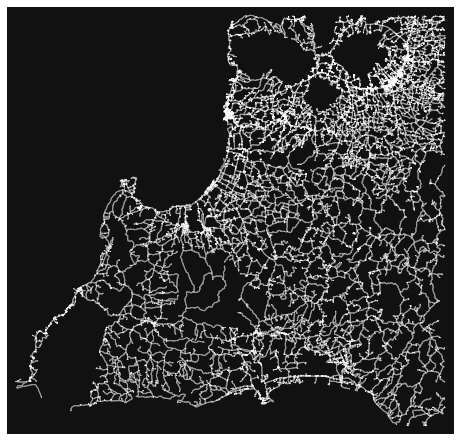

In [ ]:
#mendapatkan pandeglang area dengan osmnx
graph = ox.graph_from_bbox(-6.2143,-6.8801,106.1815,105.1996, network_type="drive")

# impute speed on all edges missing data
graph = ox.add_edge_speeds(graph)

# calculate travel time (seconds) for all edges
graph = ox.add_edge_travel_times(graph)

#menampilkan map yang didapatkan
fig, ax = ox.plot_graph(graph,node_size= 1)


CLEANSING DATA

In [ ]:
#load data toko dan kecamatan dengan meniadakan toko-toko tanpa point
df_2_clean = df_2[data_availability].copy()

#reset index agara dataframe terlihat lebih rapih
df_2_clean.reset_index(drop = True, inplace = True)

#menambahkan koordinat setiap kecamatan pada kolom baru, yaitu 'POINT'
df_2_clean['POINT'] = point_tuple

#mencari node terdekat dari point, karena node akan digunakan
#untuk mencari waktu tempuh tercepat menggunakan osmnx
regency_node = [ox.get_nearest_node(graph, i, method='euclidean')\
                    for i in df_2_clean.POINT]

#menambahkan node setiap kecamatan pada kolom baru, yaitu 'NEAREST_NODE'
df_2_clean["NEAREST_NODE"] = regency_node

#menampilkan hasil cleansing dan penambahan kolom dari data df_2
df_2_clean

,NAMA TOKO,KECAMATAN,POINT,NEAREST_NODE
0,Anugrah Wijaya,"Angsana, Pandeglang","(-6.5629566, 105.8648152)",6630264884
1,Toko Bahan Bangunan Banjar,"Banjar, Pandeglang","(-6.383913, 106.0936389)",7122161452
2,Surya Mandala,"Bojong, Pandeglang","(-6.4432148, 105.9976546)",7117490169
3,Toko Bahan Bangunan / Ahmad,"Cadasari, Pandeglang","(-6.2664793, 106.1181947)",6295313070
4,Toko Berkah / H.Agus,"Carita, Pandeglang","(-6.3146901, 105.8459414)",4356581857
5,TB. Irfan,"Cibaliung, Pandeglang","(-6.7224166, 105.7479821)",6159348529
6,PB. Riskia Putra,"Cibitung, Pandeglang","(-6.6272469, 105.8869424)",6227740169
7,PD.Rizal Makmur Jaya,"Cikeusik, Pandeglang","(-6.7098719, 105.8745772)",1925926683
8,Dinda,"Cimanggu, Pandeglang","(-6.6789151, 105.6545716)",7466156701
9,Toko Bangunan Mandiri,"Cimanuk, Pandeglang","(-6.3743304, 106.0283358)",6217382600


In [ ]:
#meniadakan toko yang kecamatannya tidak terdeteksi oleh osmnx
df_0_clean = df_0.drop(df_2['NAMA TOKO'][removed_store], axis = 1).copy()

#mengurutkan kolom agar urutan toko pada df_0_clean sama dengan 
#urutan toko pada df_2_clean
kolom_tersortir = df_0_clean.columns[:6].to_list() + df_2_clean['NAMA TOKO'].to_list()

#menyamakan urutan toko antara dua dataframe yang ada
df_0_clean = df_0_clean[kolom_tersortir]

#mendapatkan index dari barang yang tidak ada
#di semua toko pada dataframe
empty_index = df_0_clean[df_0_clean.columns[6:-3]].dropna(how = 'all').index

#meniadakan barang yang tidak tersedia di semua toko
df_0_clean = df_0_clean.iloc[empty_index]

#reset index agar lebih rapih
df_0_clean.reset_index(drop = True, inplace = True)

#menampilkan data hasil cleansing
df_0_clean

,NO,ITEM,JENIS MATERIAL,KETERANGAN,SATUAN,HARGA SATUAN DASAR,Anugrah Wijaya,Toko Bahan Bangunan Banjar,Surya Mandala,Toko Bahan Bangunan / Ahmad,Toko Berkah / H.Agus,TB. Irfan,PB. Riskia Putra,PD.Rizal Makmur Jaya,Dinda,Toko Bangunan Mandiri,Bangkuyung Putra / H.Uju,Toko terus Jaya,Toko Tiga Roda,Toko ABC,Toko Fajar Bangunan,Cahaya Tani,TB. Prima / Ranran,Toko Cahaya Tani,Harapan Putra,PD. Maju Bersama / M. Rusdi,PD. Karunia Jaya,PD. Asli Jaya / Cecep,PB. Repelita Bangunan,Toko Sumber Jaya Bangunan
0,1,Bata Merah,"BATA, BATU DAN PASIR",uk. 5 x 11x 22 cm,bh,600,650.0,500.0,500.0,500.0,500.0,NaN,600.0,800.0,NaN,480.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,600.0,500.0,480.0
1,2,Bata beton ringan ex Celcon,"BATA, BATU DAN PASIR",uk. 9 x 19 x 39 cm,bh,4500,4000.0,4000.0,4300.0,3800.0,4600.0,NaN,4200.0,4600.0,5000.0,4200.0,4300.0,4600.0,4300.0,NaN,4300.0,3800.0,4600.0,4200.0,4200.0,4600.0,4000.0,NaN,3600.0,4000.0
2,3,Batu kali,"BATA, BATU DAN PASIR",Batu belah pondasi,m3,215000,122000.0,130000.0,NaN,200000.0,NaN,NaN,120000.0,180000.0,NaN,90000.0,300000.0,140000.0,200000.0,200000.0,160000.0,NaN,NaN,240000.0,48000.0,NaN,NaN,180000.0,120000.0,200000.0
3,4,Batu Split Pecah Mesin 1/2,"BATA, BATU DAN PASIR",NaN,m3,240000,400000.0,250000.0,350000.0,240000.0,250000.0,NaN,600000.0,750000.0,NaN,500000.0,250000.0,260000.0,250000.0,250000.0,250000.0,350000.0,250000.0,300000.0,300000.0,250000.0,350000.0,250000.0,700000.0,250000.0
4,5,Batu Split Pecah Mesin 3/5,"BATA, BATU DAN PASIR",NaN,m3,235000,NaN,NaN,NaN,240000.0,NaN,NaN,NaN,NaN,NaN,NaN,250000.0,NaN,250000.0,NaN,250000.0,NaN,NaN,NaN,NaN,250000.0,200000.0,NaN,NaN,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,111,Outlet TV,PERALATAN ELEKTRIKAL,Broco,bh,12000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.0,NaN,NaN,NaN,NaN,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,113,Down light / PLC 13 W,PERALATAN ELEKTRIKAL,NaN,bh,58000,58000.0,50000.0,NaN,NaN,NaN,NaN,85000.0,NaN,NaN,NaN,NaN,45000.0,NaN,NaN,NaN,NaN,NaN,50000.0,50000.0,NaN,NaN,45000.0,NaN,NaN
106,114,Fitting plafond + lampu SL,PERALATAN ELEKTRIKAL,Panasonic,bh,14000,14000.0,20000.0,NaN,NaN,NaN,12000.0,13000.0,NaN,20000.0,NaN,NaN,15000.0,NaN,NaN,NaN,NaN,NaN,15000.0,15000.0,NaN,15000.0,2000.0,NaN,NaN
107,115,Lampu TL 2 x 18 watt grille,PERALATAN ELEKTRIKAL,Panasonic,bh,42000,50000.0,NaN,40000.0,40000.0,49000.0,45000.0,40000.0,40000.0,40000.0,NaN,38000.0,NaN,45000.0,45000.0,45000.0,40000.0,49000.0,NaN,NaN,49000.0,40000.0,40000.0,45000.0,38000.0


In [ ]:
#menampilkan titik-titik kecamatan di peta
#store_point.plot(color = 'Red', ax=ax)
#fig

PENGOLAHAN DATA

In [ ]:
#fungsi untuk menampilkan barang/kecamatan yang tersedia
#agar lebih mudah dilihat dengan cara menmbaginya menjadi beberapa kolom

def print_splitem (series, n, string_1, string_2) :
    
    #banyak item yang ditampilkan per kolom
    split_size = math.ceil(len(series)/n)
    
    #indeks item yang diambil dari dataframe : a:b
    a = 0
    b = split_size
    
    #inisiasi dictionary untuk dijadikan dataframe
    dict_reorg = {}
    
    #loop untuk membuat n-kolom dataframe
    for i in range(n):

      #mencetak kode untuk masing-masing barang
      dict_reorg[string_1+str(i+1)] = range(a+1, b+1)
      
      #mencetak barang-barang per kolom
      dict_reorg[string_2 + str(i+1)] = series[a:b].reset_index(drop= True).copy()
      
      #mendapatkan indeks data untuk kolom berikutnya
      a += split_size
      b += split_size
    
    #mengubah dictionary menjadi dataframe
    df_reorg = pd.DataFrame(dict_reorg)
    
    #mengganti nan values menjadi string kosong ('')
    df_reorg.replace(np.nan, '', regex=True, inplace = True)
    
    #menghilangkan indeks penunjuk item/kecamatan di kolom terakhir
    #yang isinya string kosong ('')
    df_reorg.loc[df_reorg[string_2+str(n)] == '', string_1+str(n)] = ''
    return df_reorg

In [ ]:
#membuat df_0_clean.ITEM menjadi 4 kolom
df_reorg = print_splitem(df_0_clean.ITEM,4,'Kode_','Item_')

#menampilkan dataframe agar indeks bawaan dari dataframe tidak ditampilkan
HTML(df_reorg.to_html(index=False))

Kode_1,Item_1,Kode_2,Item_2,Kode_3,Item_3,Kode_4,Item_4
1,Bata Merah,29,Slot Tanam,57,Wood Filler,85,"Pipa PVC dia 3"""
2,Bata beton ringan ex Celcon,30,Kait Angin,58,Thinner,86,"Pipa PVC dia 4"""
3,Batu kali,31,Grendel,59,Amplas Kayu,87,"Stop kran dia 1"""
4,Batu Split Pecah Mesin 1/2,32,Triplek t. 3 mm,60,Kwas cat,88,"Klep diameter 3/4"""
5,Batu Split Pecah Mesin 3/5,33,Triplex t. 4 mm,61,Cat Tembok kw1,89,Tangki air 1000 liter
6,Batu Kerikil,34,Triplex t. 9 mm,62,Cat Tembok kw2,90,Tangki air 500 liter
7,Pasir Beton,35,Multiplex t. 12mm,63,Plamir Tembok,91,Pelampung otomatis
8,Pasir Pasang,36,Multiplex t. 16mm,64,Lem Kayu,92,Roof Drain Metal
9,Pasir Urug,37,Keramik 30/30,65,Seal tape,93,Mesin Jet Pump kap.250 watt
10,Tanah Urug,38,Granite Tile 40/40,66,Wastafel,94,Mesin Pompa tekan kap. 150 watt


In [ ]:
#menginput barang-barang yang diinginkan
list_barang = np.array([int(i) for i in \
                        input("Masukan Kode Barang \
                        (Contoh : 15, 3, 5)\n").split(",")])

#mengurangi indeks masing-masing barang
#agar sesuai indeksnya dengan dataframe barang
list_barang = list_barang - 1
list_barang

Masukan Kode Barang                         (Contoh : 15, 3, 5)
19, 24,56, 15, 6


array([18, 23, 55, 14,  5])

In [ ]:
#mendapatkan dataframe item menjadi 4 kolom
df_reorg = print_splitem(df_2_clean.KECAMATAN,4,'Kode_','Kecamatan_')

#menampilkan dataframe agar indeks default dari dataframe tidak ditampilkan
HTML(df_reorg.to_html(index=False))

Kode_1,Kecamatan_1,Kode_2,Kecamatan_2,Kode_3,Kecamatan_3,Kode_4,Kecamatan_4
1,"Angsana, Pandeglang",7,"Cibitung, Pandeglang",13,"Koroncong, Pandeglang",19,"Pagelaran, Pandeglang"
2,"Banjar, Pandeglang",8,"Cikeusik, Pandeglang",14,"Labuan, Pandeglang",20,"Patia, Pandeglang"
3,"Bojong, Pandeglang",9,"Cimanggu, Pandeglang",15,"Mandalawangi, Pandeglang",21,"Saketi, Pandeglang"
4,"Cadasari, Pandeglang",10,"Cimanuk, Pandeglang",16,"Mekarjaya, Pandeglang",22,"Sindangresmi, Pandeglang"
5,"Carita, Pandeglang",11,"Jiput, Pandeglang",17,"Menes, Pandeglang",23,"Sukaresmi, Pandeglang"
6,"Cibaliung, Pandeglang",12,"Kaduhejo, Pandeglang",18,"Munjul, Pandeglang",24,"Sumur, Pandeglang"


In [ ]:
#mendapatkan indeks toko
indeks_toko = int(input("Kode Kecamatan tempat anda berasal : "))-1

#mendapatkan nama toko di kecamatan yang sama
nama_toko = df_0_clean.columns[indeks_toko+6]

#mendapatkan indeks barang-barang yang tersedia di toko
indeks_barang = df_0_clean[nama_toko][list_barang].dropna().index.to_list()

#inisiasi dictionary toko dan indeks dari barang yang tersedia pada toko
barang_dan_toko = {}

#input indeks barang pada dictionary dengan key nama dari toko yang dimaksud
barang_dan_toko[nama_toko] = indeks_barang

#mendapatkan list barang yang belum didapatkan dari toko sebelumnya
list_barang = [i for i in list_barang if i not in indeks_barang]

Kode Kecamatan tempat anda berasal : 6


In [ ]:
#fungsi untuk mencari waktu tempuh dari satu node ke list dari node-node
#dalam satu graph
def dict_of_travel_time(source_node, list_of_nodes, graph):
  
  #inisiasi dictionary untuk menyimpan data waktu tempuh
  dict_of_travel_time= {}
  
  #loop untuk mencari waktu tempuh dari node asal ke node tujuan
  for node in list_of_nodes:
    
    #mendapatkan serangkaian node yang ditempuh untuk mencapai node target
    #dari node asal
    route = nx.shortest_path(G=graph, source=source_node, target=node, weight='travel_time')
    
    #mendapatkan waktu tempuh dari node asal ke node tujuan
    dict_of_travel_time[node] = int(sum(ox.utils_graph.get_route_edge_attributes(graph, route, 'travel_time')))
  return dict_of_travel_time

In [ ]:
#loop jika masih ada barang yang belum ditemukan
while len(list_barang)>0:
  #mendapatkan nama-nama toko yang tersedia
  all_store = df_0_clean.columns[6:]
  
  #mensortir toko mana saja yang menyediakan barang yang belum didapatkan
  available_store = df_0_clean[all_store].iloc[list_barang].\
                  dropna(how='all', axis = 1).columns
  
  #cek apakah nama-nama toko yang ada terdapat pada toko-toko yang
  #menyediakan barang yang belum didapatkan, lalu diambil baris-baris data 
  #yand dibutuhkan
  df_matrix = df_2_clean.loc[df_2_clean["NAMA TOKO"].isin(available_store)]
  
  #mendapatkan waktu tempuh dari node asal ke node-node tujuan
  dict_of_tt = dict_of_travel_time(df_2_clean.NEAREST_NODE[indeks_toko], df_matrix.NEAREST_NODE, graph)
  
  #mencari waktu tempuh terkecil
  min_key = min(dict_of_tt, key = dict_of_tt.get)

  #mendapatkan indeks toko terdekat
  indeks_toko = df_2_clean.loc[df_2_clean.NEAREST_NODE == min_key].index[0]

  #mendapatkan nama toko terdekat
  nama_toko = df_0_clean.columns[indeks_toko+6]

  #mendapatkan barang-barang yang belum ditemukan di toko sebelumnya
  indeks_barang = df_0_clean[nama_toko][list_barang].dropna().index.to_list()
  
  #menginput toko dan barang yang tesedia pada toko tersebut
  barang_dan_toko[nama_toko] = indeks_barang

  #mencek kembali apakah ada barang yang belum ditemukan pada toko ini
  list_barang = [i for i in list_barang if i not in indeks_barang]

In [ ]:
barang_dan_toko

{'Bangkuyung Putra / H.Uju': [18],
 'Dinda': [14],
 'TB. Irfan': [23, 55],
 'Toko Sumber Jaya Bangunan': [5]}

In [ ]:
#fungsi untuk mendapatkan kuantitas yang diminta dari masing-masing barang 

def quantity_per_item(barang_dan_toko, df = df_0_clean):

  #inisiasi dictionary untuk menyimpan quantitas dari masing-masing barang
  #yang ada pada masing-masing toko
  quantity_per_toko = {}
  
  for i in barang_dan_toko:
    #list untuk menyimpan kuantitas dari barang yang ada per toko
    quantity = []
    
    #mencetak nama toko tempat barang berasal
    print(i)

    for j in barang_dan_toko[i]:
      
      #input kuantitas dari tiap-tiap barang
      #dengan menampilkan nama, harga, satuan, dan keterangan dari barang tersebut
      quantity.append(int(input(\
      "Masukan jumlah item {}\n(harga : {}, satuan : {}, keterangan : {}) \n"\
      .format(df.ITEM[j], df[i][j], df.SATUAN[j], df.KETERANGAN[j]))))
    
    quantity_per_toko[i] = quantity
  
  return quantity_per_toko

In [ ]:
quantities = quantity_per_item(barang_dan_toko)

TB. Irfan
Masukan jumlah item Engsel 
(harga : 15000.0, satuan : bh, keterangan : 3", ex Bos) 
5
Masukan jumlah item Meni kayu 
(harga : 35000.0, satuan : kg, keterangan : ex. Nippon) 
3
Dinda
Masukan jumlah item Kawat beton
(harga : 25000.0, satuan : kg, keterangan : Kawat Beton) 
5
Toko Sumber Jaya Bangunan
Masukan jumlah item Batu Kerikil
(harga : 250000.0, satuan : m3, keterangan : nan) 
3
Bangkuyung Putra / H.Uju
Masukan jumlah item Kayu Klas IV
(harga : 1800000.0, satuan : m3, keterangan : Terentang) 
1


END OF CODE

ALL UNUSED CODE ARE BELLOW

In [ ]:
'''
def plot_path(lat, long, origin_point, destination_point):
    
    """
    Given a list of latitudes and longitudes, origin 
    and destination point, plots a path on a map
    
    Parameters
    ----------
    lat, long: list of latitudes and longitudes
    origin_point, destination_point: co-ordinates of origin
    and destination
    Returns
    -------
    Nothing. Only shows the map.
    """
    # adding the lines joining the nodes
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'blue')))
    # adding source marker
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
     
    # adding destination marker
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    
    # getting center for plots:
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    # defining the layout using mapbox_style
    fig.update_layout(mapbox_style="stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()
'''

In [ ]:
nodes_proj, edges_proj = ox.graph_to_gdfs(graph, nodes=True, edges=True)
origin_point = (graph.nodes[6630264884]['y'], graph.nodes[6630264884]['x'])
dest_point = (graph.nodes[7117490169]['y'], graph.nodes[7117490169]['x'])

long = [] 
lat = []  
for i in route:
     point = graph.nodes[i]
     long.append(point['x'])
     lat.append(point['y'])

o_closest = nodes_proj.loc[orig_node]
t_closest = nodes_proj.loc[target_node]
# Create a GeoDataFrame from the origin and target points
od_nodes = gpd.GeoDataFrame([o_closest, t_closest], geometry='geometry', crs=nodes_proj.crs)
od_nodes.head()

edges = ox.graph_to_gdfs(graph, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

In [ ]:
'''
def show_data(column_number, df):
    check = df[df.columns[column_number]].isnull().tolist()
    item_col = df.columns[0]
    check_item = [df[item_col][i] for i in range(len(df)) if check[i] == False]
    df_1 = pd.DataFrame(data = check_item, columns = ['ITEM'])
    df_1['HARGA'] = [df[df.columns[4]][i] for i in range(0, len(df)) if check[i] == False]
    #df_1.set_index([pd.Index(range(1, len(df_1)+1))], inplace = True)
    print('Daftar harga per item di',df.columns[column_number])
    return df_1
'''

In [ ]:
%whos

Interactive namespace is empty.


In [ ]:
# Calculate the area
#area = convex_hull.area

# Calculate statistics with density information
#stats = ox.basic_stats(graph_proj, area=area)
#extended_stats = ox.extended_stats(graph_proj, ecc=True, cc=True) #RAM Eater!!!!

# Add extened statistics to the basic statistics
#for key, value in extended_stats.items():
#    stats[key] = value

# Convert the dictionary to a Pandas series for a nicer output
#pd.Series(stats)
#prog = re.compile('(([0-9]+)\s*,\s*)')
#df_0_clean[df_0_clean.columns[6:]].iloc[looking_for].dropna(how='all', axis = 1).sort_values(by = 108, axis = 1, ascending = True).iloc[0,0]
#df_0_clean[df_0_clean.columns[6:]].iloc[looking_for].dropna(how='all', axis = 1).sort_values(by = 108, axis = 1, ascending = True).columns[0]

#def point_to_node(point):
#  # Get origin x and y coordinates
#  orig_xy = (point.y, point.x)